In [130]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout , Flatten, Dense, Normalization, Resizing
from tensorflow.keras.regularizers import L2
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
from IPython import display
from IPython import display


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\up\\c1d39ce8_nohash_6.wav', shape=(), dtype=string)


In [5]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [6]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

## PART I. AUDIO CONVERSION

In [118]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(input=file_path,sep=os.path.sep)
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def get_spectrogram(waveform):
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def plot_all(command_type):
    df = command_df[command_df['command'] == command_type].head()
    fig, axes = plt.subplots(row,col,figsize=(18,8))
    for i in range(len(df)):
        axes[0][i].plot(df.iloc[i,0])
        axes[0][i].set_title(command_type)
        plot_spectrogram(df.iloc[i,1], axes[1][i])

def plot_all2(command_type):    
    fig, axes = plt.subplots(4,4,figsize=(18,15))
    for i in range(len(command_type)):
        if i <8:
            r = i // 4
            c = i % 4
            df = command_df[command_df['command'] == command_type[i]].head(1)
            axes[r][c].plot(df.iloc[0,0],color='yellowgreen')
            axes[r][c].set_title(command_type[i])
        else:
            r = i // 4
            c = i % 4
            df = command_df[command_df['command'] == command_type[i]].head(1)
            plot_spectrogram(df.iloc[0,1], axes[r][c])
            axes[r][c].set_title(command_type[i])
            
def command(command_df):
    fig, axes = plt.subplots(2,2,figsize=(15,10))
    sns.boxplot(x='command',y='mean',data=command_df[(command_df['mean'] > -0.0001) & (command_df['mean'] < 0.0001)],ax=axes[0][0])
    sns.boxplot(x='command',y='min',data=command_df,ax=axes[0][1])
    sns.boxplot(x='command',y='max',data=command_df,ax=axes[1][0])
    sns.boxplot(x='command',y='sd',data=command_df,ax=axes[1][1])
    plt.show()

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

#Wavefrom Conversion
waveform_ds = files_ds.map(map_func=get_waveform_and_label,num_parallel_calls=AUTOTUNE)

#Spectrogram Conversion
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)

audio_all = []
label_all = []
for i,(audio,label) in enumerate(waveform_ds.take(2000)):
    audio_all.append(audio.numpy())
    label_all.append(label.numpy().decode('utf-8'))

spect = []
label_ids = []
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(2000)):
    spect.append(spectrogram.numpy())
    label_ids.append(commands[label_id.numpy()])

In [110]:
command_df = pd.DataFrame(zip(audio_all,spect,label_all),columns=['audio','spectrogram','command'])
command_df['mean'] = command_df['audio'].apply(lambda x: np.mean(x))
command_df['max'] = command_df['audio'].apply(lambda x: np.max(x))
command_df['min'] = command_df['audio'].apply(lambda x: np.min(x))
command_df['sd'] = command_df['audio'].apply(lambda x: np.std(x))
command_df.head()

,audio,spectrogram,command,mean,max,min,sd
0,"[-0.0028381348, -0.0034179688, -0.0035095215, ...","[[[0.0337566], [0.06329206], [0.07135755], [0....",up,0.000024,0.683746,-0.853699,0.082110
1,"[-9.1552734e-05, -0.00015258789, -3.0517578e-0...","[[[0.038405992], [0.068906054], [0.044825632],...",left,-0.000078,0.362854,-0.586853,0.039798
2,"[0.0014648438, 0.0016479492, 0.0025634766, 0.0...","[[[0.011805547], [0.040136755], [0.0073109795]...",up,-0.000001,0.243439,-0.222290,0.023589
3,"[-0.00048828125, -0.0005493164, -0.00076293945...","[[[0.014983168], [0.014552402], [0.01890048], ...",left,-0.000071,0.369354,-0.593384,0.052571
4,"[0.00033569336, 0.0014343262, 0.0012817383, 0....","[[[0.033416856], [0.0147695085], [0.07023265],...",right,0.000043,0.225647,-0.161713,0.040586


## PART II : EXPLORATORY DATA ANALYSIS
#### 5 Example of Wave form and Spectrogrma of "UP" command

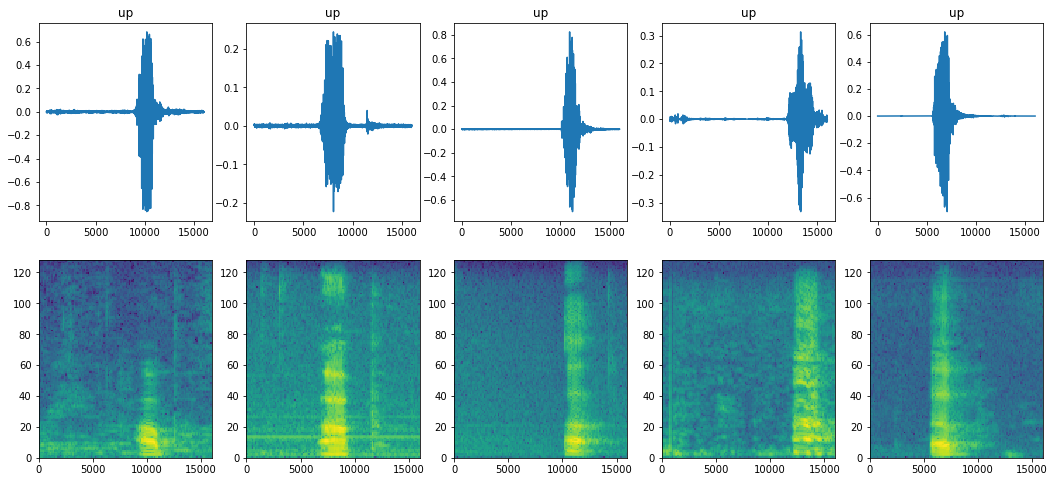

In [47]:
plot_all('up')

#### 5 Example of Wave form and Spectrogrma of "DOWN" command

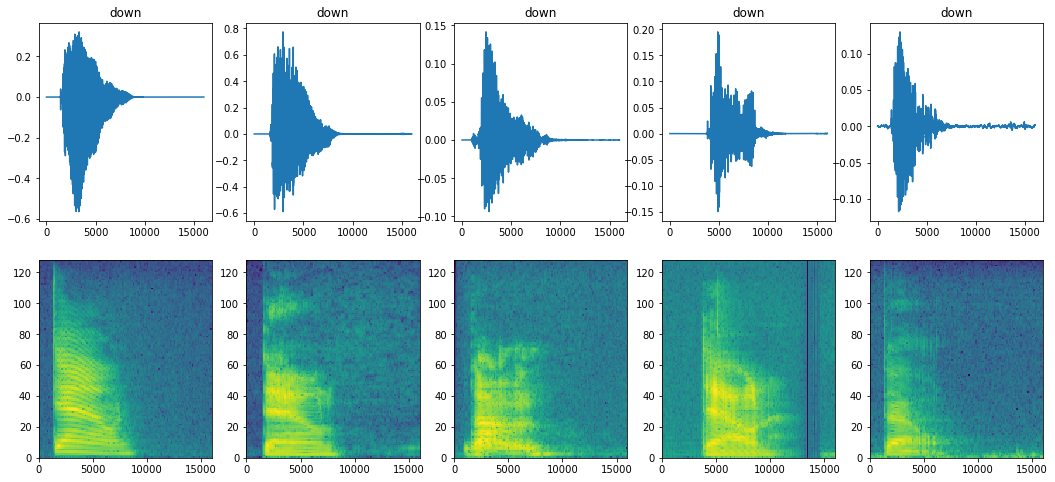

In [48]:
plot_all('down')

#### 5 Example of Wave form and Spectrogrma of "LEFT" command

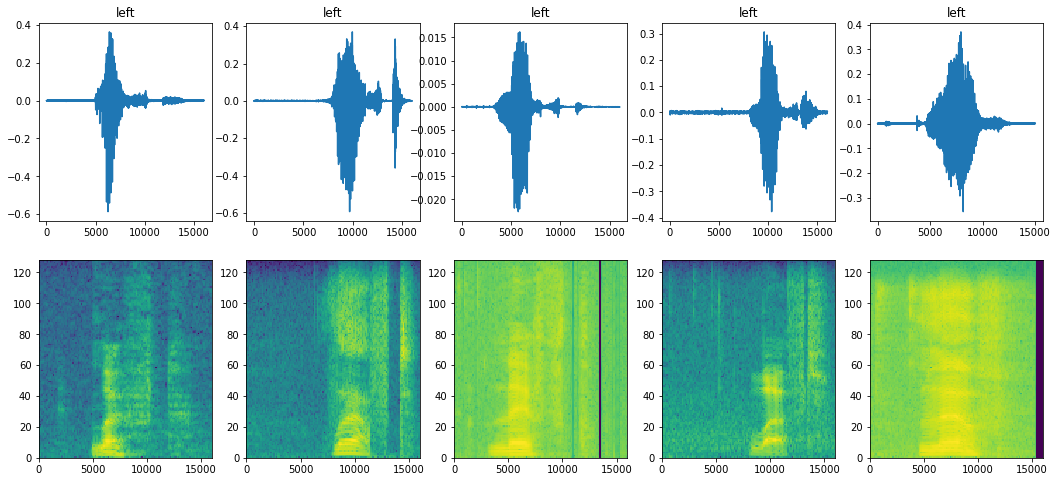

In [49]:
plot_all('left')

#### 5 Example of Wave form and Spectrogrma of "RIGHT" command

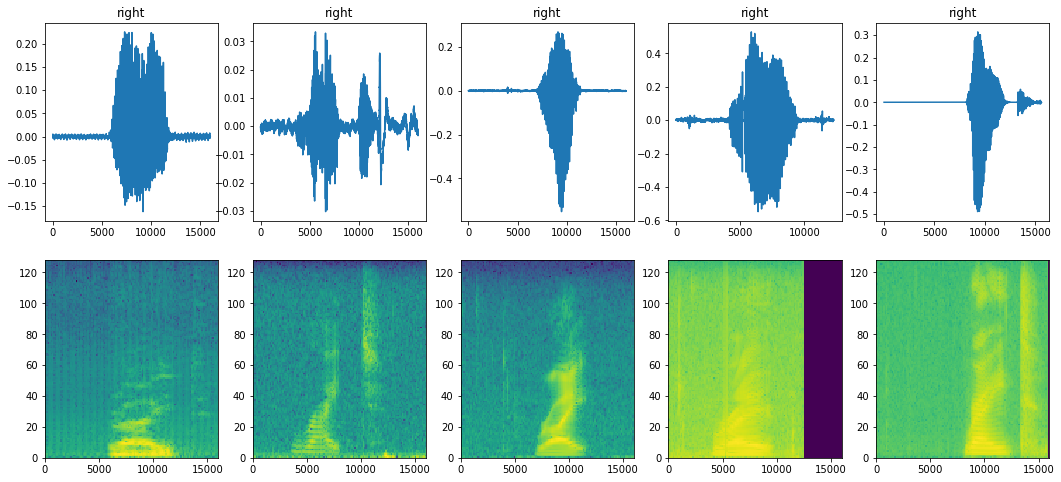

In [50]:
plot_all('right')

#### 5 Example of Wave form and Spectrogrma of "GO" command

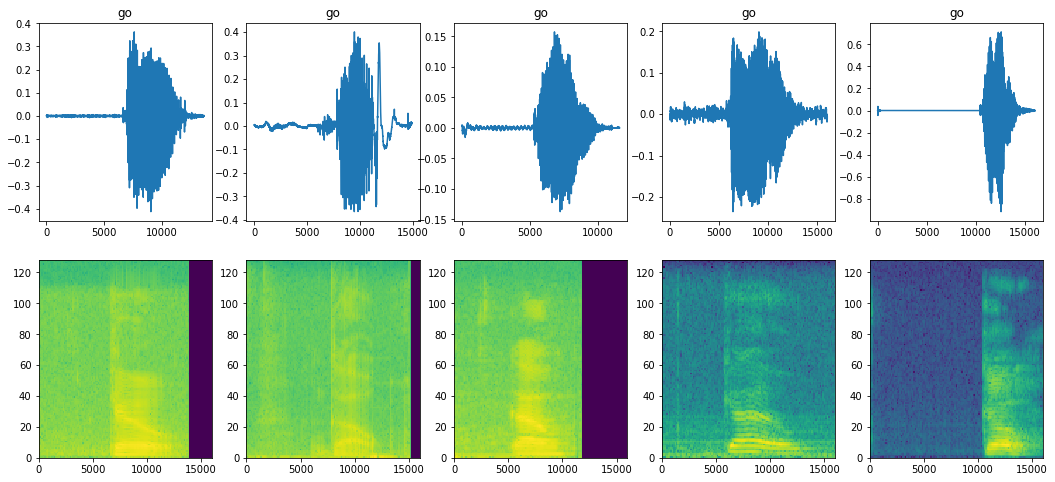

In [51]:
plot_all('go')

#### 5 Example of Wave form and Spectrogrma of "STOP" command

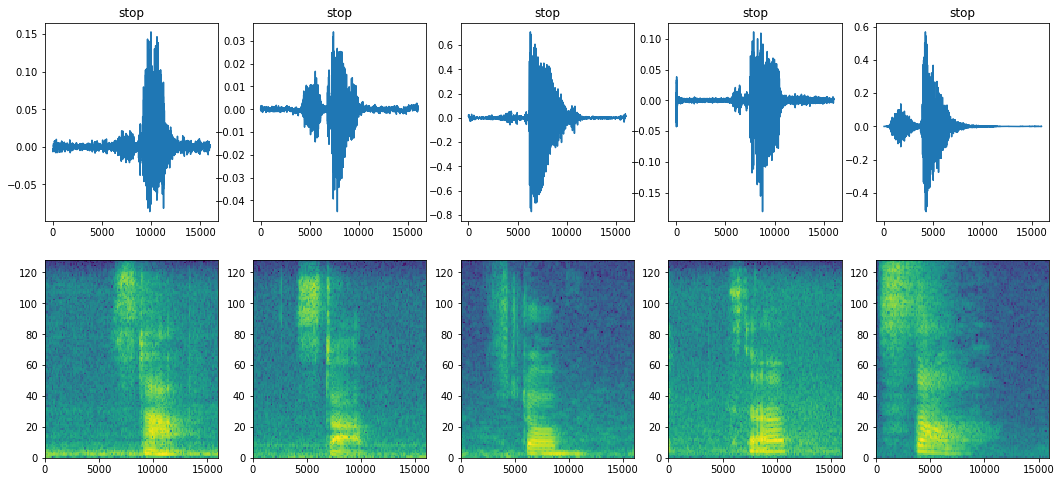

In [52]:
plot_all('stop')

#### 5 Example of Wave form and Spectrogrma of "YES" command

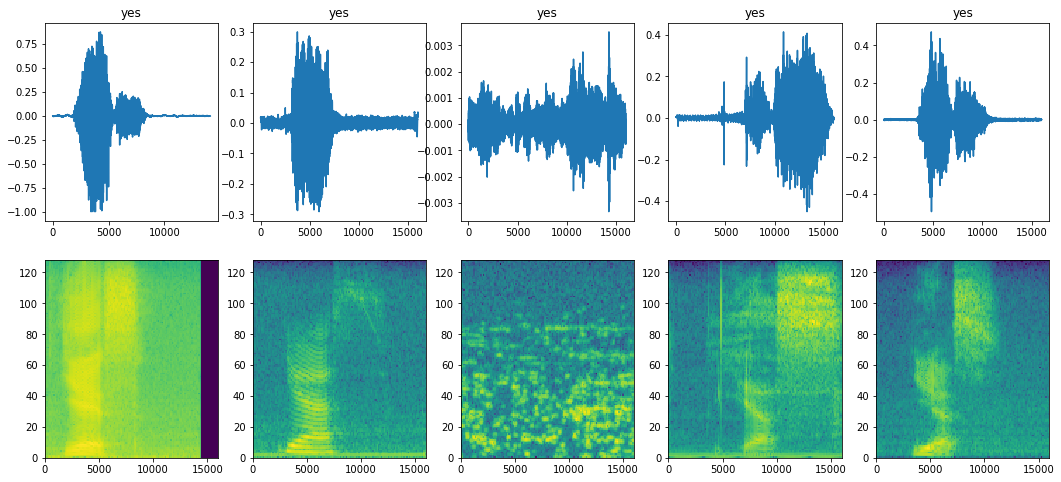

In [53]:
plot_all('yes')

#### 5 Example of Wave form and Spectrogrma of "NO" command

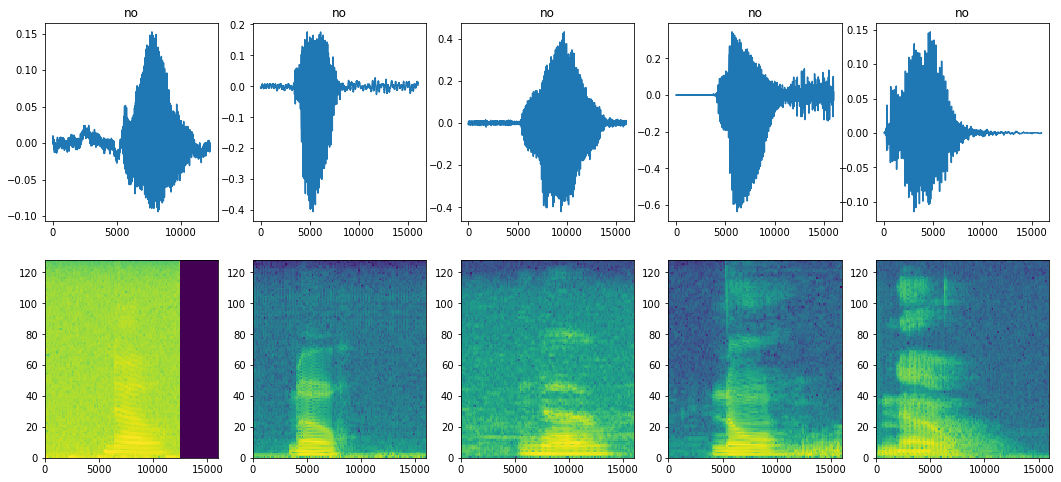

In [54]:
plot_all('no')

####  Example of Wave form and Spectrogrma of All command

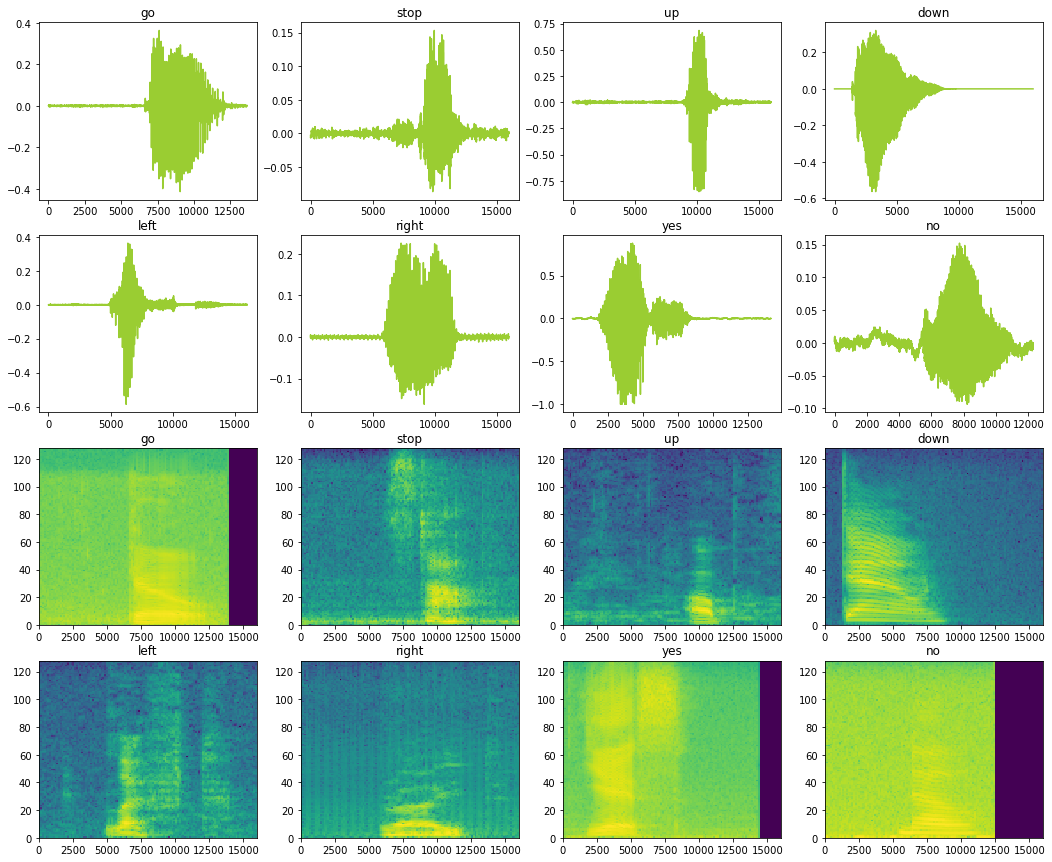

In [79]:
plot_all2(['go','stop','up','down','left','right','yes','no','go','stop','up','down','left','right','yes','no'])

## Command Distribution

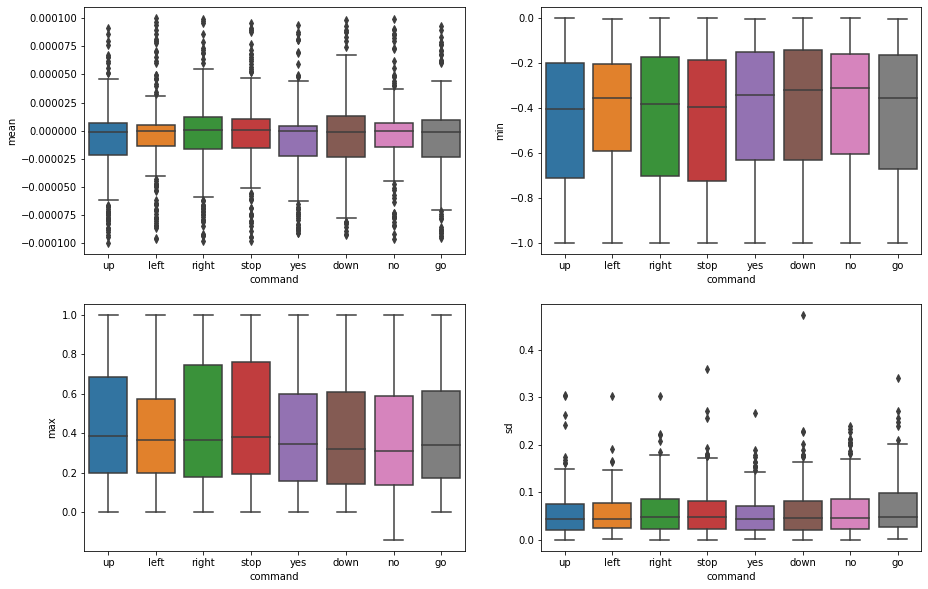

In [119]:
command(command_df)

## PART III : PREPROCESSING

In [125]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(map_func=get_waveform_and_label,num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)
  return output_ds

In [128]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [131]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)

num_labels = len(commands)
norm_layer = Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

Input shape: (124, 129, 1)


## PART IV BASE LINE MODEL

In [132]:
model = models.Sequential()
model.add(Input(shape=input_shape))
model.add(Resizing(32, 32))
model.add(norm_layer)
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_labels))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 128)               9

In [133]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics='accuracy')
es = EarlyStopping(verbose=1, patience=2)

In [134]:
history = model.fit(train_ds,validation_data=val_ds,epochs=30,callbacks=es)

Epoch 1/30
100/100 [==============================] - 8s 73ms/step - loss: 1.6575 - accuracy: 0.4169 - val_loss: 1.3506 - val_accuracy: 0.5500
Epoch 2/30
100/100 [==============================] - 2s 20ms/step - loss: 1.1782 - accuracy: 0.6025 - val_loss: 1.1401 - val_accuracy: 0.6212
Epoch 3/30
100/100 [==============================] - 2s 19ms/step - loss: 0.9400 - accuracy: 0.6780 - val_loss: 1.0046 - val_accuracy: 0.6600
Epoch 4/30
100/100 [==============================] - 2s 20ms/step - loss: 0.7857 - accuracy: 0.7306 - val_loss: 0.9221 - val_accuracy: 0.6913
Epoch 5/30
100/100 [==============================] - 2s 19ms/step - loss: 0.6763 - accuracy: 0.7745 - val_loss: 0.9020 - val_accuracy: 0.6913
Epoch 6/30
100/100 [==============================] - 2s 20ms/step - loss: 0.5897 - accuracy: 0.8031 - val_loss: 0.8881 - val_accuracy: 0.6975
Epoch 7/30
100/100 [==============================] - 2s 19ms/step - loss: 0.5133 - accuracy: 0.8277 - val_loss: 0.8539 - val_accuracy: 0.7075

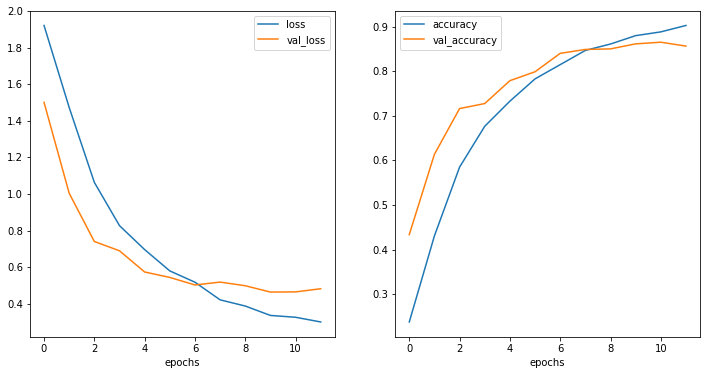

In [170]:
metrics = history.history
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(history.epoch, metrics['loss'], metrics['val_loss'])
ax2.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
ax1.legend(['loss', 'val_loss'])
ax2.legend(['accuracy', 'val_accuracy'])
ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')
plt.show()


## PART V: FINE TUNE MODEL
### FIRST ATTEMPTs (Baseline + one CNN layers)

In [137]:
model = models.Sequential()
model.add(Input(shape=input_shape))
model.add(Resizing(32, 32))
model.add(norm_layer)
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_labels))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)            

In [138]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics='accuracy')
es = EarlyStopping(verbose=1, patience=2)

In [139]:
history1 = model.fit(train_ds,validation_data=val_ds,epochs=30,callbacks=es)

Epoch 1/30
100/100 [==============================] - 8s 72ms/step - loss: 1.5411 - accuracy: 0.4634 - val_loss: 1.1024 - val_accuracy: 0.6087
Epoch 2/30
100/100 [==============================] - 7s 71ms/step - loss: 0.8820 - accuracy: 0.7063 - val_loss: 0.7789 - val_accuracy: 0.7250
Epoch 3/30
100/100 [==============================] - 7s 73ms/step - loss: 0.6034 - accuracy: 0.7930 - val_loss: 0.6770 - val_accuracy: 0.7638
Epoch 4/30
100/100 [==============================] - 8s 75ms/step - loss: 0.4194 - accuracy: 0.8611 - val_loss: 0.6014 - val_accuracy: 0.7962
Epoch 5/30
100/100 [==============================] - 7s 74ms/step - loss: 0.3206 - accuracy: 0.8973 - val_loss: 0.5967 - val_accuracy: 0.8012
Epoch 6/30
100/100 [==============================] - 7s 74ms/step - loss: 0.2551 - accuracy: 0.9202 - val_loss: 0.5517 - val_accuracy: 0.8188
Epoch 7/30
100/100 [==============================] - 7s 74ms/step - loss: 0.2111 - accuracy: 0.9330 - val_loss: 0.6202 - val_accuracy: 0.8050

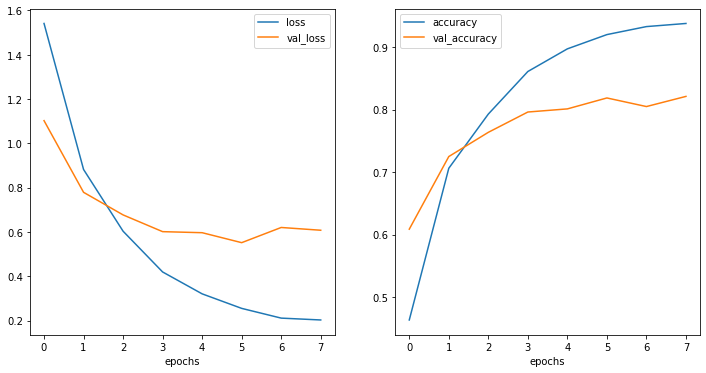

In [171]:
metrics = history1.history
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(history1.epoch, metrics['loss'], metrics['val_loss'])
ax2.plot(history1.epoch, metrics['accuracy'], metrics['val_accuracy'])
ax1.legend(['loss', 'val_loss'])
ax2.legend(['accuracy', 'val_accuracy'])
ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')
plt.show()

### SECOND ATTEMPTS (Baseline + OneCNN/MaxPool Layers)

In [141]:
model = models.Sequential()
model.add(Input(shape=input_shape))
model.add(Resizing(32, 32))
model.add(norm_layer)
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_labels))


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)        

In [142]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics='accuracy')
es = EarlyStopping(verbose=1, patience=2)

In [143]:
history2 = model.fit(train_ds,validation_data=val_ds,epochs=30,callbacks=es)

Epoch 1/30
100/100 [==============================] - 3s 30ms/step - loss: 1.6624 - accuracy: 0.4316 - val_loss: 1.2958 - val_accuracy: 0.5600
Epoch 2/30
100/100 [==============================] - 3s 30ms/step - loss: 1.1077 - accuracy: 0.6319 - val_loss: 0.9938 - val_accuracy: 0.6575
Epoch 3/30
100/100 [==============================] - 3s 31ms/step - loss: 0.8433 - accuracy: 0.7161 - val_loss: 0.8416 - val_accuracy: 0.7150
Epoch 4/30
100/100 [==============================] - 3s 31ms/step - loss: 0.6971 - accuracy: 0.7663 - val_loss: 0.8356 - val_accuracy: 0.7275
Epoch 5/30
100/100 [==============================] - 3s 30ms/step - loss: 0.5941 - accuracy: 0.7977 - val_loss: 0.7300 - val_accuracy: 0.7600
Epoch 6/30
100/100 [==============================] - 3s 31ms/step - loss: 0.4931 - accuracy: 0.8384 - val_loss: 0.6807 - val_accuracy: 0.7750
Epoch 7/30
100/100 [==============================] - 3s 32ms/step - loss: 0.4349 - accuracy: 0.8539 - val_loss: 0.6334 - val_accuracy: 0.7875

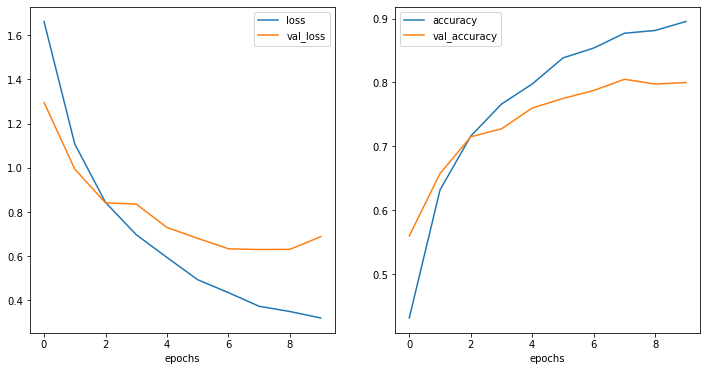

In [172]:
metrics = history2.history
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(history2.epoch, metrics['loss'], metrics['val_loss'])
ax2.plot(history2.epoch, metrics['accuracy'], metrics['val_accuracy'])
ax1.legend(['loss', 'val_loss'])
ax2.legend(['accuracy', 'val_accuracy'])
ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')
plt.show()

### THIRD ATTEMPTS (Baseline + One Layers+L2)

In [147]:
model = models.Sequential()
model.add(Input(shape=input_shape))
model.add(Resizing(32, 32))
model.add(norm_layer)
model.add(Conv2D(32, 3, activation='relu',kernel_regularizer=L2(0.03)))
model.add(Conv2D(64, 3, activation='relu',kernel_regularizer=L2(0.03)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_labels))


model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 12544)            

In [148]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics='accuracy')
es = EarlyStopping(verbose=1, patience=2)

In [149]:
history3 = model.fit(train_ds,validation_data=val_ds,epochs=30,callbacks=es)

Epoch 1/30
100/100 [==============================] - 8s 72ms/step - loss: 2.0984 - accuracy: 0.4238 - val_loss: 1.4809 - val_accuracy: 0.5600
Epoch 2/30
100/100 [==============================] - 8s 80ms/step - loss: 1.2466 - accuracy: 0.6358 - val_loss: 1.1467 - val_accuracy: 0.6575
Epoch 3/30
100/100 [==============================] - 7s 74ms/step - loss: 0.9603 - accuracy: 0.7308 - val_loss: 0.9553 - val_accuracy: 0.7138
Epoch 4/30
100/100 [==============================] - 7s 75ms/step - loss: 0.8162 - accuracy: 0.7797 - val_loss: 0.8688 - val_accuracy: 0.7350
Epoch 5/30
100/100 [==============================] - 7s 73ms/step - loss: 0.7272 - accuracy: 0.8155 - val_loss: 0.8669 - val_accuracy: 0.7475
Epoch 6/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6621 - accuracy: 0.8319 - val_loss: 0.8091 - val_accuracy: 0.7850
Epoch 7/30
100/100 [==============================] - 7s 75ms/step - loss: 0.5956 - accuracy: 0.8608 - val_loss: 0.8162 - val_accuracy: 0.7800

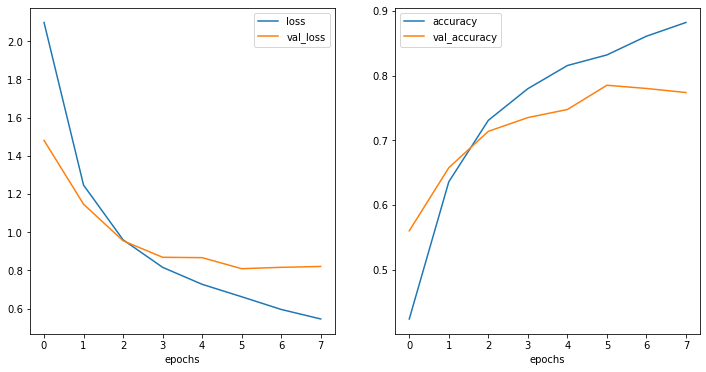

In [173]:
metrics = history3.history
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(history3.epoch, metrics['loss'], metrics['val_loss'])
ax2.plot(history3.epoch, metrics['accuracy'], metrics['val_accuracy'])
ax1.legend(['loss', 'val_loss'])
ax2.legend(['accuracy', 'val_accuracy'])
ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')
plt.show()

### FORTH  ATTEMPTs (Baseline + One CNN + Dropout)

In [151]:
model = models.Sequential()
model.add(Input(shape=input_shape))
model.add(Resizing(32, 32))
model.add(norm_layer)
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)       

In [152]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics='accuracy')
es = EarlyStopping(verbose=1, patience=2)

In [153]:
history4 = model.fit(train_ds,validation_data=val_ds,epochs=30,callbacks=es)

Epoch 1/30
100/100 [==============================] - 9s 84ms/step - loss: 1.7132 - accuracy: 0.3875 - val_loss: 1.2328 - val_accuracy: 0.5763
Epoch 2/30
100/100 [==============================] - 8s 85ms/step - loss: 1.1325 - accuracy: 0.6000 - val_loss: 0.8492 - val_accuracy: 0.7100
Epoch 3/30
100/100 [==============================] - 8s 82ms/step - loss: 0.8649 - accuracy: 0.6939 - val_loss: 0.7160 - val_accuracy: 0.7500
Epoch 4/30
100/100 [==============================] - 8s 83ms/step - loss: 0.6944 - accuracy: 0.7594 - val_loss: 0.6440 - val_accuracy: 0.7900
Epoch 5/30
100/100 [==============================] - 8s 84ms/step - loss: 0.5941 - accuracy: 0.7956 - val_loss: 0.5858 - val_accuracy: 0.8050
Epoch 6/30
100/100 [==============================] - 8s 84ms/step - loss: 0.5289 - accuracy: 0.8125 - val_loss: 0.5693 - val_accuracy: 0.8112
Epoch 7/30
100/100 [==============================] - 8s 84ms/step - loss: 0.4650 - accuracy: 0.8405 - val_loss: 0.5157 - val_accuracy: 0.8300

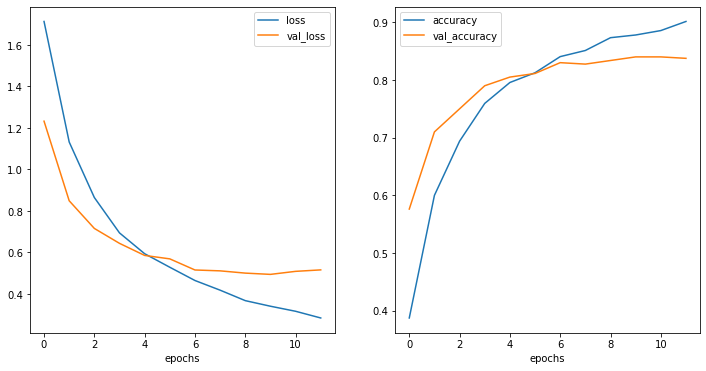

In [174]:
metrics = history4.history
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(history4.epoch, metrics['loss'], metrics['val_loss'])
ax2.plot(history4.epoch, metrics['accuracy'], metrics['val_accuracy'])
ax1.legend(['loss', 'val_loss'])
ax2.legend(['accuracy', 'val_accuracy'])
ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')
plt.show()

### FIFTH ATTEMPTS (Baseline + Two CNN Layers + Dropout)

In [155]:
model = models.Sequential()
model.add(Input(shape=input_shape))
model.add(Resizing(32, 32))
model.add(norm_layer)
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                  

In [156]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics='accuracy')
es = EarlyStopping(verbose=1, patience=2)

In [157]:
history5 = model.fit(train_ds,validation_data=val_ds,epochs=30,callbacks=es)

Epoch 1/30
100/100 [==============================] - 22s 219ms/step - loss: 1.6214 - accuracy: 0.4175 - val_loss: 1.0589 - val_accuracy: 0.6375
Epoch 2/30
100/100 [==============================] - 22s 221ms/step - loss: 0.9615 - accuracy: 0.6622 - val_loss: 0.7238 - val_accuracy: 0.7412
Epoch 3/30
100/100 [==============================] - 23s 228ms/step - loss: 0.6733 - accuracy: 0.7581 - val_loss: 0.6263 - val_accuracy: 0.7812
Epoch 4/30
100/100 [==============================] - 22s 223ms/step - loss: 0.5340 - accuracy: 0.8144 - val_loss: 0.5780 - val_accuracy: 0.8100
Epoch 5/30
100/100 [==============================] - 23s 226ms/step - loss: 0.4252 - accuracy: 0.8508 - val_loss: 0.4861 - val_accuracy: 0.8313
Epoch 6/30
100/100 [==============================] - 23s 232ms/step - loss: 0.3618 - accuracy: 0.8709 - val_loss: 0.4676 - val_accuracy: 0.8425
Epoch 7/30
100/100 [==============================] - 23s 228ms/step - loss: 0.3161 - accuracy: 0.8894 - val_loss: 0.4238 - val_ac

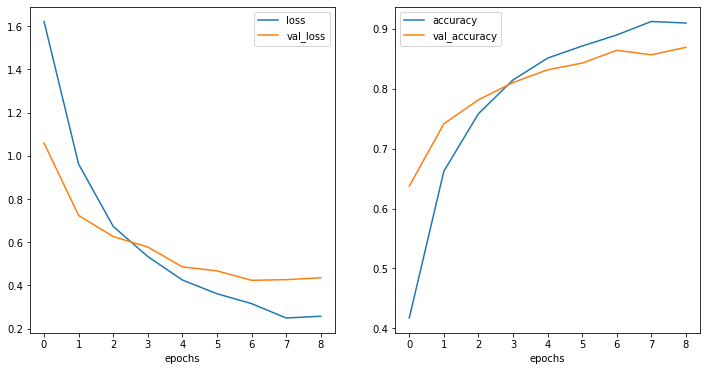

In [175]:
metrics = history5.history
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(history5.epoch, metrics['loss'], metrics['val_loss'])
ax2.plot(history5.epoch, metrics['accuracy'], metrics['val_accuracy'])
ax1.legend(['loss', 'val_loss'])
ax2.legend(['accuracy', 'val_accuracy'])
ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')
plt.show()

### SIXTH ATTEMPTS (Baeline + 4 CNN Layers + Dropout)

In [164]:
model = models.Sequential()
model.add(Input(shape=input_shape))
model.add(Resizing(32, 32))
model.add(norm_layer)
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(128, 3, activation='relu'))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))


model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_7 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 26, 26, 128)       73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 256)       295168    
                                                      

In [165]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics='accuracy')
es = EarlyStopping(verbose=1, patience=2)

In [166]:
history6 = model.fit(train_ds,validation_data=val_ds,epochs=30,callbacks=es)

Epoch 1/30
100/100 [==============================] - 60s 597ms/step - loss: 1.9460 - accuracy: 0.2372 - val_loss: 1.6651 - val_accuracy: 0.3725
Epoch 2/30
100/100 [==============================] - 61s 610ms/step - loss: 1.5233 - accuracy: 0.4356 - val_loss: 1.0530 - val_accuracy: 0.6075
Epoch 3/30
100/100 [==============================] - 64s 643ms/step - loss: 1.0455 - accuracy: 0.6142 - val_loss: 0.8250 - val_accuracy: 0.6875
Epoch 4/30
100/100 [==============================] - 63s 628ms/step - loss: 0.8637 - accuracy: 0.6837 - val_loss: 0.6830 - val_accuracy: 0.7325
Epoch 5/30
100/100 [==============================] - 62s 623ms/step - loss: 0.7008 - accuracy: 0.7480 - val_loss: 0.5974 - val_accuracy: 0.7825
Epoch 6/30
100/100 [==============================] - 61s 608ms/step - loss: 0.5802 - accuracy: 0.7867 - val_loss: 0.6034 - val_accuracy: 0.7862
Epoch 7/30
100/100 [==============================] - 59s 590ms/step - loss: 0.5362 - accuracy: 0.8077 - val_loss: 0.5279 - val_ac

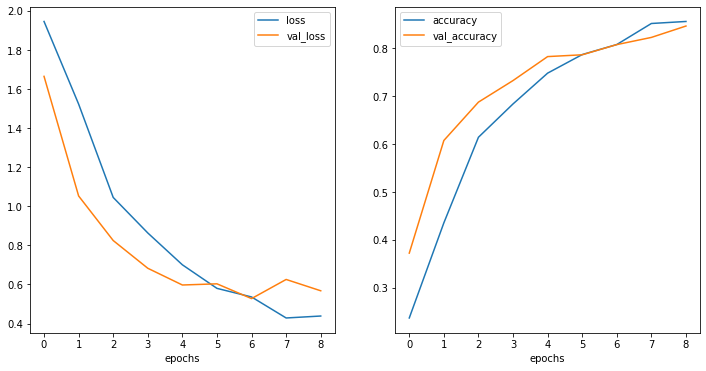

In [176]:
metrics = history6.history
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(history6.epoch, metrics['loss'], metrics['val_loss'])
ax2.plot(history6.epoch, metrics['accuracy'], metrics['val_accuracy'])
ax1.legend(['loss', 'val_loss'])
ax2.legend(['accuracy', 'val_accuracy'])
ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')
plt.show()